In [3]:
from patsy import *
# 경고 무시
import warnings
warnings.simplefilter('ignore')

# 자주 사용하는 패키지를 임포트
import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import sklearn as sk
import pgmpy
import scipy.stats

# matplotlib 설정
mpl.use('Agg')

# seaborn 설정
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

%matplotlib inline

### 부츠트랩

In [4]:
from sklearn.datasets import make_regression

X0, y, coef = make_regression(n_samples=100, n_features=1, noise=20,
                              coef=True, random_state=0)
coef

array(42.38550486)

In [6]:
dfX0 = pd.DataFrame(X0, columns=["X1"])
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(y, columns=["y"])

model = sm.OLS(dfy, dfX)
result = model.fit()

In [8]:
result.params

const    -1.628364
X1       42.853356
dtype: float64

In [9]:
%%time
N = 1000
params_w0 = np.zeros(N)
params_w1 = np.zeros(N)
for i in range(N):
    idx = np.random.choice(len(dfy), len(dfy), replace=True)
    dfX2 = dfX.iloc[idx, :]
    dfy2 = dfy.iloc[idx]
    r = sm.OLS(dfy2, dfX2).fit()
    params_w0[i] = r.params.const
    params_w1[i] = r.params.X1

Wall time: 1.93 s


Font 'default' does not have a glyph for '\ucd94' [U+cd94], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\uc815' [U+c815], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\uce58' [U+ce58], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ubd84' [U+bd84], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ud3ec' [U+d3ec], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ucd94' [U+cd94], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\uc815' [U+c815], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\uce58' [U+ce58], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ubd84' [U+bd84], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ud3ec' [U+d3ec], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\ucd94' [U+cd94], 

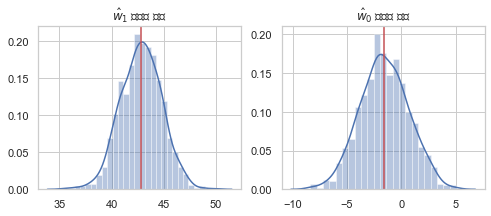

In [11]:
plt.figure(figsize=(8, 3))

ax1 = plt.subplot(121)
sns.distplot(params_w1, ax=ax1)
plt.axvline(params_w1.mean(), c='r')
plt.title("$\hat{w}_1$ 추정치 분포")

ax2 = plt.subplot(122)
sns.distplot(params_w0, ax=ax2)
plt.axvline(params_w0.mean(), c='r')
plt.title("$\hat{w}_0$ 추정치 분포")
plt.show()

In [12]:
params_w1.mean(), params_w1.std()

(42.823947980515264, 1.9523926618140004)

In [13]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Sat, 08 Aug 2020   Prob (F-statistic):           2.21e-36
Time:                        11:36:58   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6284      2.163     -0.753      0.4

### 잔차의 분포

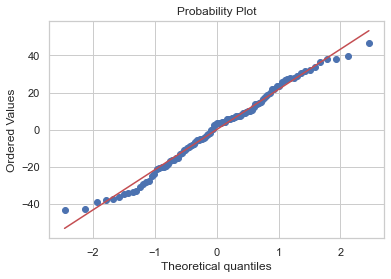

In [7]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

In [14]:
test = sm.stats.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  3.523
P-value     :  0.172


In [15]:
test = sm.stats.jarque_bera(result.resid)
for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test):
    print("%-12s: %6.3f" % xi)

Jarque-Bera :  2.059
P-value     :  0.357
Skew        : -0.073
Kurtosis    :  2.312


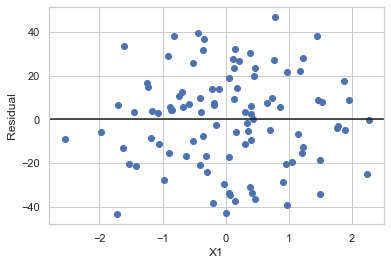

In [16]:
plt.plot(X0, result.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("X1")
plt.ylabel("Residual")
plt.show()

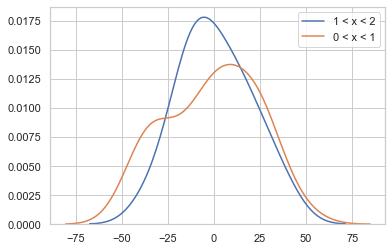

In [17]:
sns.kdeplot(result.resid[((1 < X0) & (X0 < 2)).flatten()], label="1 < x < 2")
sns.kdeplot(result.resid[((0 < X0) & (X0 < 1)).flatten()], label="0 < x < 1")
plt.legend()
plt.show()

### 단일 계수 t-검정

In [18]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Sat, 08 Aug 2020   Prob (F-statistic):           2.21e-36
Time:                        12:33:40   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6284      2.163     -0.753      0.4

In [19]:
# w1을 40으로 해도 되는지에 대한 테스트
print(result.t_test("X1 = 40"))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            42.8534      2.142      1.332      0.186      38.603      47.104


In [20]:
import datetime
from calendar import isleap

df_nottem = sm.datasets.get_rdataset("nottem").data 

def convert_partial_year(number):
    year = int(number)
    d = datetime.timedelta(days=(number - year) * (365 + isleap(year)))
    day_one = datetime.datetime(year, 1, 1)
    date = d + day_one
    return date

df_nottem["date0"] = df_nottem[["time"]].applymap(convert_partial_year)
df_nottem["date"] = pd.DatetimeIndex(df_nottem["date0"]).round('60min') + datetime.timedelta(seconds=3600*24)
df_nottem["month"] = df_nottem["date"].dt.strftime("%m").astype('category')
del df_nottem["date0"], df_nottem["date"]

model_nottem = sm.OLS.from_formula("value ~ C(month) + 0", df_nottem)
result_nottem = model_nottem.fit()
print(result_nottem.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     277.3
Date:                Sat, 08 Aug 2020   Prob (F-statistic):          2.96e-125
Time:                        12:34:48   Log-Likelihood:                -535.82
No. Observations:                 240   AIC:                             1096.
Df Residuals:                     228   BIC:                             1137.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
C(month)[01]    39.6950      0.518     76.691   

In [21]:
# 1월과 2월은 구분이 불필요
print(result_nottem.t_test("C(month)[01] = C(month)[02]"))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.5050      0.732      0.690      0.491      -0.937       1.947


In [22]:
# 2월과 3월은 구분이 필요
print(result_nottem.t_test("C(month)[03] = C(month)[02]"))

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             3.0050      0.732      4.105      0.000       1.563       4.447
